In [1]:
# Necessary outsource packages for this jupyter notebook

!pip install missingno
!pip install pyampute
!pip install hiclass
!pip install optuna
!pip install plotly
!pip install lightgbm
!pip install hierarchical_confusion_matrix

In [2]:
# Import necessary packages
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import random
import optuna
import numba
import time
import networkx as nx

from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from hiclass import LocalClassifierPerNode, FlatClassifier
from hiclass.metrics import f1
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from hierarchical_confusion_matrix import determineHierarchicalConfusionMatrix, printHierarchicalConfusionMatrix

In [3]:
# Running time_start
whole_time_start = time.time()

# 1 Get the data

In [4]:
# Read in data
raw_data = pd.read_csv("ALL.csv", low_memory=False)

# Keep useful cols
columns_keep = ["tic",     # ticker
                "gsubind", # GICS code
                "fyear",   # fiscal year
                "at",      # total assets
                "che",     # cash and short-term investments
                "rect",    # receivables
                "invt",    # inventory
                "act",     # current assets
                "ppent",   # property, plant and equipment (net)
                "ivaeq",   # investment and advances
                "intan",   # intangible assets
                "ap",      # accounts payable
                "dlc",     # debt in current laibilities
                "ui",      # unearned income
                "lct",     # current liabilities
                "dltt",    # long-term debt
                "lt",      # total liabilities
                "pstk",    # preferred stock
                "ceq",     # common equity
                "sale",    # sales/turnover
                "cogs",    # cost of goods sold
                "xrd",     # research and development expense
                "ib"     # income before extraordinary items
    ]

raw_data = raw_data[columns_keep]

# Check the size and type of data
raw_shape1 = raw_data.shape
print(f"The size of raw_data is {raw_shape1}.")

raw_data.info()

The size of raw_data is (128458, 23).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128458 entries, 0 to 128457
Data columns (total 23 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   tic      128405 non-null  object 
 1   gsubind  94265 non-null   float64
 2   fyear    128235 non-null  float64
 3   at       93066 non-null   float64
 4   che      82283 non-null   float64
 5   rect     81271 non-null   float64
 6   invt     84474 non-null   float64
 7   act      69108 non-null   float64
 8   ppent    90405 non-null   float64
 9   ivaeq    87965 non-null   float64
 10  intan    91885 non-null   float64
 11  ap       86228 non-null   float64
 12  dlc      92398 non-null   float64
 13  ui       3589 non-null    float64
 14  lct      69210 non-null   float64
 15  dltt     92825 non-null   float64
 16  lt       92957 non-null   float64
 17  pstk     92721 non-null   float64
 18  ceq      92849 non-null   float64
 19  sale     81918 non-null   f

In [5]:
raw_data.sort_values("tic")

,tic,gsubind,fyear,at,che,rect,invt,act,ppent,ivaeq,...,ui,lct,dltt,lt,pstk,ceq,sale,cogs,xrd,ib
1530,0015B,25504010.0,2013.0,2613.936,161.56,35.678,720.052,1012.989,902.657,0.0,...,NaN,856.356,1301.012,2655.631,0.0,-41.695,4461.987,2706.375,0.0,43.75
9551,0032A,55105010.0,2014.0,21333.000,1845.00,588.000,468.000,3469.000,12288.000,NaN,...,NaN,1542.000,1510.000,39807.000,0.0,-18474.000,5978.000,4464.000,NaN,-6229.00
9552,0032A,55105010.0,2015.0,15628.000,1919.00,533.000,428.000,3422.000,9349.000,NaN,...,NaN,2826.000,23.000,38618.000,0.0,-22990.000,5370.000,4202.000,NaN,-4603.00
9550,0033A,55105010.0,2015.0,23330.000,2810.00,533.000,428.000,4323.000,9430.000,6064.0,...,NaN,8512.000,60.000,48391.000,0.0,-25061.000,5370.000,4271.000,NaN,-5342.00
9549,0033A,55105010.0,2014.0,29248.000,3434.00,589.000,468.000,5083.000,12397.000,6058.0,...,NaN,1795.000,6953.000,48971.000,0.0,-19723.000,5978.000,4550.000,NaN,-6406.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111782,NaN,NaN,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111915,NaN,NaN,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112254,NaN,NaN,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112255,NaN,NaN,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocessing

In [5]:
# Preprocess the target attributes
def process_labels(dataset):
    dataset = dataset.dropna(subset=["gsubind"]) # drop rows without GICS codes
    dataset = dataset.reset_index(drop=True)     # reset index

    dataset["GICS"] = dataset["gsubind"].apply(int).apply(str)  # convert data type into strings and assign new colname
    dataset.drop(columns=["gsubind"], inplace=True)             # drop original target attribute      
    dataset.reset_index(drop=True, inplace=True)                # reset index

    return dataset

raw_data = process_labels(raw_data)

# Check data shape
raw_shape2 = raw_data.shape
print(f"{raw_shape1[0] - raw_shape2[0]} rows are dropped because of no labels.")
print(f"The size of raw_data is {raw_shape2}.")

34193 rows are dropped because of no labels.
The size of raw_data is (94265, 23).


In [6]:
def drop_duplicates(dataset):
    cleaned_dataframes = []

    for year in dataset["fyear"].unique():
        # Filter data for the current year
        data = dataset[dataset["fyear"] == year]
        
        # Find duplicates based on the 'tic' column
        duplicates = data[data.duplicated("tic", keep=False)].sort_values("tic")

        def which_to_drop(company):
            # Find the index of the row with the fewest missing values
            return company.isnull().sum(axis=1).idxmax()

        # Apply the which_to_keep function to each group of duplicates
        indices_to_drop = duplicates.groupby("tic").apply(which_to_drop).values.tolist()

        # Drop the duplicates, keeping only the selected indices
        data_cleaned = data.drop(index=indices_to_drop)
        
        # Append the cleaned data to the list
        cleaned_dataframes.append(data_cleaned)

    # Concatenate all cleaned dataframes into a single dataframe
    cleaned_dataset = pd.concat(cleaned_dataframes)

    return cleaned_dataset

raw_data = drop_duplicates(raw_data)

/tmp/ipykernel_337/2718078486.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_to_drop = duplicates.groupby("tic").apply(which_to_drop).values.tolist()
/tmp/ipykernel_337/2718078486.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_to_drop = duplicates.groupby("tic").apply(which_to_drop).values.tolist()
/tmp/ipykernel_337/2718078486.py:16: DeprecationWarning: DataFrameGroupBy.apply op

##### Missing "tic"

In [7]:
# Check obs. with "tic" missing
raw_data[raw_data["tic"].isna()]

,tic,fyear,at,che,rect,invt,act,ppent,ivaeq,intan,...,lct,dltt,lt,pstk,ceq,sale,cogs,xrd,ib,GICS
13789,NaN,2014.0,31.713,2.174,NaN,0.000,3.345,9.046,18.422,0.000,...,5.582,0.000,6.425,0.000,23.693,3.919,8.130,NaN,-5.541,40203010
15816,NaN,2014.0,846.271,20.948,31.704,0.000,NaN,0.000,255.930,12.490,...,NaN,226.596,561.944,184.358,99.969,50.296,4.680,NaN,-26.678,40402045
67222,NaN,2014.0,88204.000,8127.000,41219.000,0.000,NaN,124.000,93.000,62.000,...,NaN,239.000,83204.000,350.000,4450.000,2795.000,781.000,NaN,639.000,40101010
67223,NaN,2014.0,88204.000,NaN,NaN,NaN,NaN,124.000,93.000,62.000,...,NaN,239.000,83204.000,350.000,4450.000,NaN,NaN,NaN,639.000,40101010
13790,NaN,2015.0,31.103,3.993,NaN,0.000,5.050,5.752,19.679,0.000,...,5.211,0.000,6.285,0.000,24.467,2.610,4.200,NaN,-1.512,40203010
67224,NaN,2015.0,94024.000,8345.000,48378.000,0.000,NaN,110.000,60.000,61.000,...,NaN,239.000,88648.000,850.000,4526.000,2594.000,791.000,NaN,442.000,40101010
67225,NaN,2015.0,94024.000,NaN,NaN,NaN,NaN,110.000,60.000,61.000,...,NaN,239.000,88648.000,850.000,4526.000,NaN,NaN,NaN,442.000,40101010
13791,NaN,2016.0,29.187,3.590,NaN,0.000,10.318,0.000,18.263,0.000,...,6.053,0.000,6.053,0.000,23.052,0.000,0.000,NaN,-1.193,40203010
67226,NaN,2016.0,94657.000,7133.000,46907.000,0.000,NaN,104.000,46.000,70.000,...,NaN,1039.000,89242.000,850.000,4565.000,2694.000,724.000,NaN,524.000,40101010
67227,NaN,2016.0,94657.000,NaN,NaN,NaN,NaN,104.000,46.000,70.000,...,NaN,1039.000,89242.000,850.000,4565.000,NaN,NaN,NaN,524.000,40101010


In [8]:
# Drop duplicates manually
index_drop_dup = [67223, 67225, 67227, 67229, 67231, 67233, 67235, 67237, 67239, 67241]
raw_data = raw_data.drop(index=index_drop_dup)

raw_data = raw_data.drop(columns=["tic", "fyear"])

# Check data shape
raw_shape3 =  raw_data.shape
print(f"{raw_shape2[0] - raw_shape3[0]} duplicated obs. are dropped.")
print(f"The size of raw_data is {raw_shape3}.")

11001 duplicated obs. are dropped.
The size of raw_data is (83264, 21).


##### Total assets
"at" is the total assets. \
Since we need to use common size based on it, "at" must be available and positive.

In [9]:
def clean_at(dataset):
    # Drop rows without "at"
    dataset.dropna(subset=["at"], inplace=True)

    # Drop rows with "at" < 1
    dataset.drop(index = dataset[dataset["at"] <= 0].index, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

    return dataset

raw_data = clean_at(raw_data)

# Check data shape
raw_shape4 =  raw_data.shape
print(f"{raw_shape3[0] - raw_shape4[0]} obs. are dropped because of cleaning at.")
print(f"The size of raw_data is {raw_shape4}.")

2479 obs. are dropped because of cleaning at.
The size of raw_data is (80785, 21).


In [10]:
# Filter out balance sheet items >= total assets
def clean_balance_sheet_at(dataset):
    index1 = set()
    for col in dataset.columns[1:16]:
        indices = dataset[dataset[col] >= dataset["at"]].index
        index1.update(indices)

    dataset.drop(index=index1, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

    return dataset

raw_data = clean_balance_sheet_at(raw_data)

raw_shape5 =  raw_data.shape
print(f"{raw_shape4[0] - raw_shape5[0]} obs. are dropped because of balance sheet items >= at.")
print(f"The size of raw_data is {raw_shape5}.")

11161 obs. are dropped because of balance sheet items >= at.
The size of raw_data is (69624, 21).


In [11]:
# Filter out balance sheet items < 0
def clean_balance_sheet_0(dataset):
    index2 = set()
    for col in dataset.columns[1:16]:
        indices = dataset[dataset[col] <0].index
        index2.update(indices)

    dataset.drop(index=index2, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

    return dataset

raw_data = clean_balance_sheet_0(raw_data)

raw_shape6 =  raw_data.shape
print(f"{raw_shape5[0] - raw_shape6[0]} obs. are dropped because of balance sheet items < 0.")
print(f"The size of raw_data is {raw_shape6}.")

811 obs. are dropped because of balance sheet items < 0.
The size of raw_data is (68813, 21).


In [12]:
def clean_sale(dataset):
    # Drop rows without "sale"
    dataset.dropna(subset=["sale"], inplace=True)

    # Drop rows with "sale" <=0
    dataset.drop(index = dataset[dataset["sale"] <= 0].index, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

    return dataset

raw_data = clean_sale(raw_data)

# Check data shape
raw_shape7 =  raw_data.shape
print(f"{raw_shape6[0] - raw_shape7[0]} obs. are dropped because of cleaning sales.")
print(f"The size of raw_data is {raw_shape7}.")

7380 obs. are dropped because of cleaning sales.
The size of raw_data is (61433, 21).


In [13]:
def clean_invt(dataset):
    # Drop rows without "invt"
    dataset.dropna(subset=["invt"], inplace=True)

    # Drop rows with "invt" <=0
    dataset.drop(index = dataset[dataset["invt"] <= 0].index, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

    return dataset

raw_data = clean_invt(raw_data)

# Check data shape
raw_shape8 =  raw_data.shape
print(f"{raw_shape7[0] - raw_shape8[0]} obs. are dropped because of cleaning sales.")
print(f"The size of raw_data is {raw_shape8}.")

20090 obs. are dropped because of cleaning sales.
The size of raw_data is (41343, 21).


In [14]:
gics_codes = [
    "10101010", "10101020", 
    "10102010", "10102020", "10102030", "10102040", "10102050",
    "15101010", "15101020", "15101030", "15101040", "15101050", 
    "15102010", 
    "15103010", "15103020",
    "15104010", "15104020", "15104025", "15104030", "15104040", "15104045", "15104050", 
    "15105010", "15105020", 
    "20101010", 
    "20102010", "20103010", 
    "20104010", "20104020", 
    "20105010", 
    "20106010", "20106015", "20106020", 
    "20107010", 
    "20201010", "20201050","20201060", "20201070", "20201080", 
    "20202010", "20202020", "20202030", 
    "20301010", 
    "20302010",
    "20303010", 
    "20304010", "20304030", "20304040",
    "20305010", "20305020", "20305030",
    "25101010", "25102010", 
    "25102020", "25102020",
    "25201010", "25201020", "25201030", "25201040", "25201050",
    "25202010", 
    "25203010", "25203020", "25203030", 
    "25301010", "25301020", "25301030", "25301040",
    "25302010", "25302020", 
    "25501010",
    "25503030",
    "25504010", "25504020", "25504030", "25504040", "25504050", "25504060",
    "30101010", "30101020", "30101030", "30101040", 
    "30201010", "30201020", "30201030", 
    "30202010", "30202030", 
    "30203010",
    "30301010", 
    "30302010", 
    "35101010", "35101020", 
    "35102010", "35102015", "35102020", "35102030", 
    "35103010", 
    "35201010", 
    "35202010", 
    "35203010",
    "40101010", "40101015", 
    "40201020", "40201030", 
    "40201040", "40201050", "40201060", 
    "40202010",
    "40203010", "40203020", "40203030", "40203040",
    "40204010", 
    "40301010", "40301020", "40301030", "40301040", "40301050",
    "45102010", "45102030",
    "45103010", "45103020", 
    "45201020", 
    "45202030", 
    "45203010", "45203015", "45203020", "45203030",
    "45301010", "45301020", 
    "50101010", "50101020", 
    "50102010",
    "50201010", "50201020", "50201030", "50201040", 
    "50202010", "50202020", 
    "50203010",
    "55101010", 
    "55102010", 
    "55103010", 
    "55104010", 
    "55105010", "55105020", 
    "60101010", 
    "60102510", 
    "60103010", 
    "60104010",
    "60105010", 
    "60106010", "60106020", 
    "60107010",
    "60108010", "60108020", "60108030", "60108040", "60108050", 
    "60201010", "60201020", "60201030", "60201040"
]

In [15]:
len(gics_codes)

163

In [16]:
raw_data = raw_data[raw_data["GICS"].isin(gics_codes)]

In [18]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40806 entries, 0 to 41342
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   at      40806 non-null  float64
 1   che     40804 non-null  float64
 2   rect    40654 non-null  float64
 3   invt    40806 non-null  float64
 4   act     34472 non-null  float64
 5   ppent   40689 non-null  float64
 6   ivaeq   37700 non-null  float64
 7   intan   40328 non-null  float64
 8   ap      40690 non-null  float64
 9   dlc     40800 non-null  float64
 10  ui      0 non-null      float64
 11  lct     34462 non-null  float64
 12  dltt    40701 non-null  float64
 13  lt      40757 non-null  float64
 14  pstk    40704 non-null  float64
 15  ceq     40735 non-null  float64
 16  sale    40806 non-null  float64
 17  cogs    40806 non-null  float64
 18  xrd     19917 non-null  float64
 19  ib      40806 non-null  float64
 20  GICS    40806 non-null  object 
dtypes: float64(20), object(1)
memory usage: 

### Sample a test set

In [19]:
# Train test split
train_X, test_X, train_y, test_y = train_test_split(raw_data.drop(columns=["GICS"]), # features
                                                    raw_data["GICS"],                # label
                                                    test_size=0.3,                   # test size
                                                    random_state=42,                 # for reproducibility
                                                    shuffle=True)                    # shuffle the data for randomness

train_data = pd.concat([train_X, train_y], axis=1)  # combine features and label

There should be concerns on when to split the dataset. \
Based on instruction from Geron, this is the right place, as we may need to manipulate the training set without influence of the test set. \
However, there are problems, such as data imbalance, missing values, and duplicated observations, needing further consideration.

In [20]:
train_y.nunique()

155

In [21]:
test_y.nunique()

156

In [22]:
# Data imbalance

# Function to calculate imbalance ratios
def imbalance_ratio(dataset, label):
    
    # Initialize
    labelPaths = dataset[label]                     # label paths from dataset
    countDict = labelPaths.value_counts().to_dict() # number of samples in dataset labelled with path
    maxCount = max(countDict.values())              # max number of label path in countDict
    IRLbP = {}                                      # empty dict

    # For loop to calculate imbalance ratio per label
    for path in labelPaths:                         
        pathCount = countDict[path]
        IRLbP[path] = round(maxCount/pathCount, 2)
    # For loop ends

    # hierarchical mean imbalance ratio
    HMeanIR = round(sum(IRLbP.values()) / len(IRLbP), 2)

    return IRLbP, HMeanIR

# Function for retrieving minority paths
def min_Paths(dataset, label):

    # Initialize
    IRLbP, HMeanIR = imbalance_ratio(dataset, label) # get imbalce ratio
    minPaths = []                                    # empty list

    # For loop to get minority classes
    for path in dataset[label]:
        if IRLbP[path] > HMeanIR:
            minPaths.append(path)
    # For loop ends

    return minPaths

# Hierarchical random oversampling (full depth)
def HROS_FD(dataset, label, random_state, s=0.1):
    
    # Initialize
    samplesToCreate = int(len(dataset)*s) # number of samples to be created
    minPaths = min_Paths(dataset, label)  # get minority paths
    new_data = dataset.copy()             # copy original dataset
    np.random.seed(random_state)          # for reproducibility

    maxIncrease = samplesToCreate / len(minPaths)   # max number of samples created for each path
    meanSize = dataset[label].value_counts().mean() # the average number of samples of all paths

    # For loop to do oversampling for each minority path
    for labelPath in minPaths:
        numSamples = (dataset[label] == labelPath).sum()
        increased = 0
        # While loop begins
        while increased < maxIncrease and numSamples < meanSize:
            sample_to_duplicate = dataset[dataset[label] == labelPath].sample(n=1, replace=True)
            new_data = pd.concat([new_data, sample_to_duplicate], ignore_index=True)
            numSamples = numSamples + 1
            increased = increased + 1
        # While loop ends
    # For loop ends

    return new_data

This random oversampling method is simply duplicating samples, which may cause overfitting problem. \
We could consider other methods for oversampling, such as SMOTE and ADASYN. \
However, we have a large number of classes and some classes only have one sample. \
Maybe we can use firm-year data instead of one-year data, and this may be of help to mitigate the imbalance problem.

# 2 Explore the data

In [23]:
# Create a copy of data for exploration
explore_df = train_data.copy(deep=True)

### Characteristics of each attribute

In [24]:
# Name
explore_df.columns

Index(['at', 'che', 'rect', 'invt', 'act', 'ppent', 'ivaeq', 'intan', 'ap',
       'dlc', 'ui', 'lct', 'dltt', 'lt', 'pstk', 'ceq', 'sale', 'cogs', 'xrd',
       'ib', 'GICS'],
      dtype='object')

In [25]:
# Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
explore_df.dtypes

at       float64
che      float64
rect     float64
invt     float64
act      float64
ppent    float64
ivaeq    float64
intan    float64
ap       float64
dlc      float64
ui       float64
lct      float64
dltt     float64
lt       float64
pstk     float64
ceq      float64
sale     float64
cogs     float64
xrd      float64
ib       float64
GICS      object
dtype: object

In [26]:
# Statistical summary
explore_df.describe()

,at,che,rect,invt,act,ppent,ivaeq,intan,ap,dlc,ui,lct,dltt,lt,pstk,ceq,sale,cogs,xrd,ib
count,2.856400e+04,2.856300e+04,2.845500e+04,28564.000000,24097.000000,28467.000000,26403.000000,28241.000000,2.848600e+04,28558.000000,0.0,24088.000000,28495.000000,2.853100e+04,28491.000000,28512.000000,28564.000000,28564.000000,13881.00000,28564.000000
mean,1.947975e+04,2.476595e+03,5.728808e+03,1155.338502,2726.839847,3559.968951,335.991801,2088.366463,6.612421e+03,1405.966347,NaN,2181.674370,3447.196605,1.516794e+04,73.151499,4029.592711,6068.413126,3976.426203,303.92234,444.108347
std,1.212968e+05,2.340799e+04,5.088897e+04,11835.735449,10270.602244,14285.238216,2259.362745,9545.754794,6.688940e+04,13589.304747,NaN,8808.380401,15237.031698,1.098784e+05,866.650279,15948.887015,23784.657991,17526.529032,1665.12911,2484.501670
min,1.500000e-02,0.000000e+00,0.000000e+00,0.001000,0.012000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,NaN,0.002000,0.000000,2.000000e-03,0.000000,0.000000,0.001000,-3703.000000,-0.64800,-22819.000000
25%,2.219980e+02,1.592300e+01,1.612050e+01,5.493000,63.525000,17.474000,0.000000,1.200000,9.594750e+00,1.002500,NaN,28.059500,6.278500,8.404700e+01,0.000000,78.847250,77.912250,31.908500,0.83600,-5.260000
50%,1.274489e+03,8.264700e+01,1.391710e+02,44.227000,330.937000,156.100000,0.000000,51.597000,7.830650e+01,15.135500,NaN,164.000000,155.000000,7.068680e+02,0.000000,400.110500,558.548500,288.754000,12.64600,16.163000
75%,6.116227e+03,3.983925e+02,7.516325e+02,288.000000,1377.000000,1255.155500,4.369000,642.722000,5.777250e+02,153.433750,NaN,876.151250,1374.939500,3.910627e+03,0.000000,1836.987500,2976.020250,1771.648250,81.45500,180.520500
max,3.743567e+06,1.007321e+06,1.218880e+06,530917.000000,264889.386000,292684.091000,59124.000000,310197.000000,2.462303e+06,469464.962000,NaN,227561.873000,343739.198000,3.449440e+06,34838.000000,561273.000000,608481.000000,452776.000000,85622.00000,99803.000000


### Missing values

In [27]:
# % of missing values
def prop_na(dataset):
    global prop_na_col
    prop_na_col = round((dataset.isna().sum() / len(dataset)) * 100, 2).sort_values(ascending=False)
    prop_na = round((dataset.isna().sum().sum() / dataset.size) * 100, 2)

    print(f"Proportion of missing values in each attributes:")
    print(prop_na_col)
    print(f"\n{prop_na}% values are missing in total.")

# % of zero values
def prop_0(dataset):
    global prop_0_col
    prop_0_col = round(((dataset == 0).sum() / len(dataset)) * 100, 2).sort_values(ascending=False)
    prop_0 = round(((dataset == 0).sum().sum() / dataset.size) * 100, 2)

    print(f"Proportion of zero values in each attributes:")
    print(prop_0_col)
    print(f"\n{prop_0}% values are zero in total.")

prop_na(explore_df)
prop_0(explore_df)

Proportion of missing values in each attributes:
ui       100.00
xrd       51.40
lct       15.67
act       15.64
ivaeq      7.57
intan      1.13
rect       0.38
ppent      0.34
ap         0.27
pstk       0.26
dltt       0.24
ceq        0.18
lt         0.12
dlc        0.02
cogs       0.00
ib         0.00
at         0.00
sale       0.00
che        0.00
invt       0.00
GICS       0.00
dtype: float64

9.2% values are missing in total.
Proportion of zero values in each attributes:
pstk     89.67
ivaeq    64.72
intan    17.88
dlc      14.25
dltt     11.31
xrd       8.10
che       0.82
rect      0.57
ap        0.44
ppent     0.21
cogs      0.03
ceq       0.01
ib        0.01
at        0.00
sale      0.00
ui        0.00
lt        0.00
lct       0.00
act       0.00
invt      0.00
GICS      0.00
dtype: float64

9.91% values are zero in total.


In [28]:
# Total propotion of na and 0
prop_0na_col = (prop_na_col + prop_0_col).sort_values(ascending=False)
prop_0na_col

ui       100.00
pstk      89.93
ivaeq     72.29
xrd       59.50
intan     19.01
lct       15.67
act       15.64
dlc       14.27
dltt      11.55
rect       0.95
che        0.82
ap         0.71
ppent      0.55
ceq        0.19
lt         0.12
cogs       0.03
ib         0.01
invt       0.00
at         0.00
sale       0.00
GICS       0.00
dtype: float64

p value: 0.0


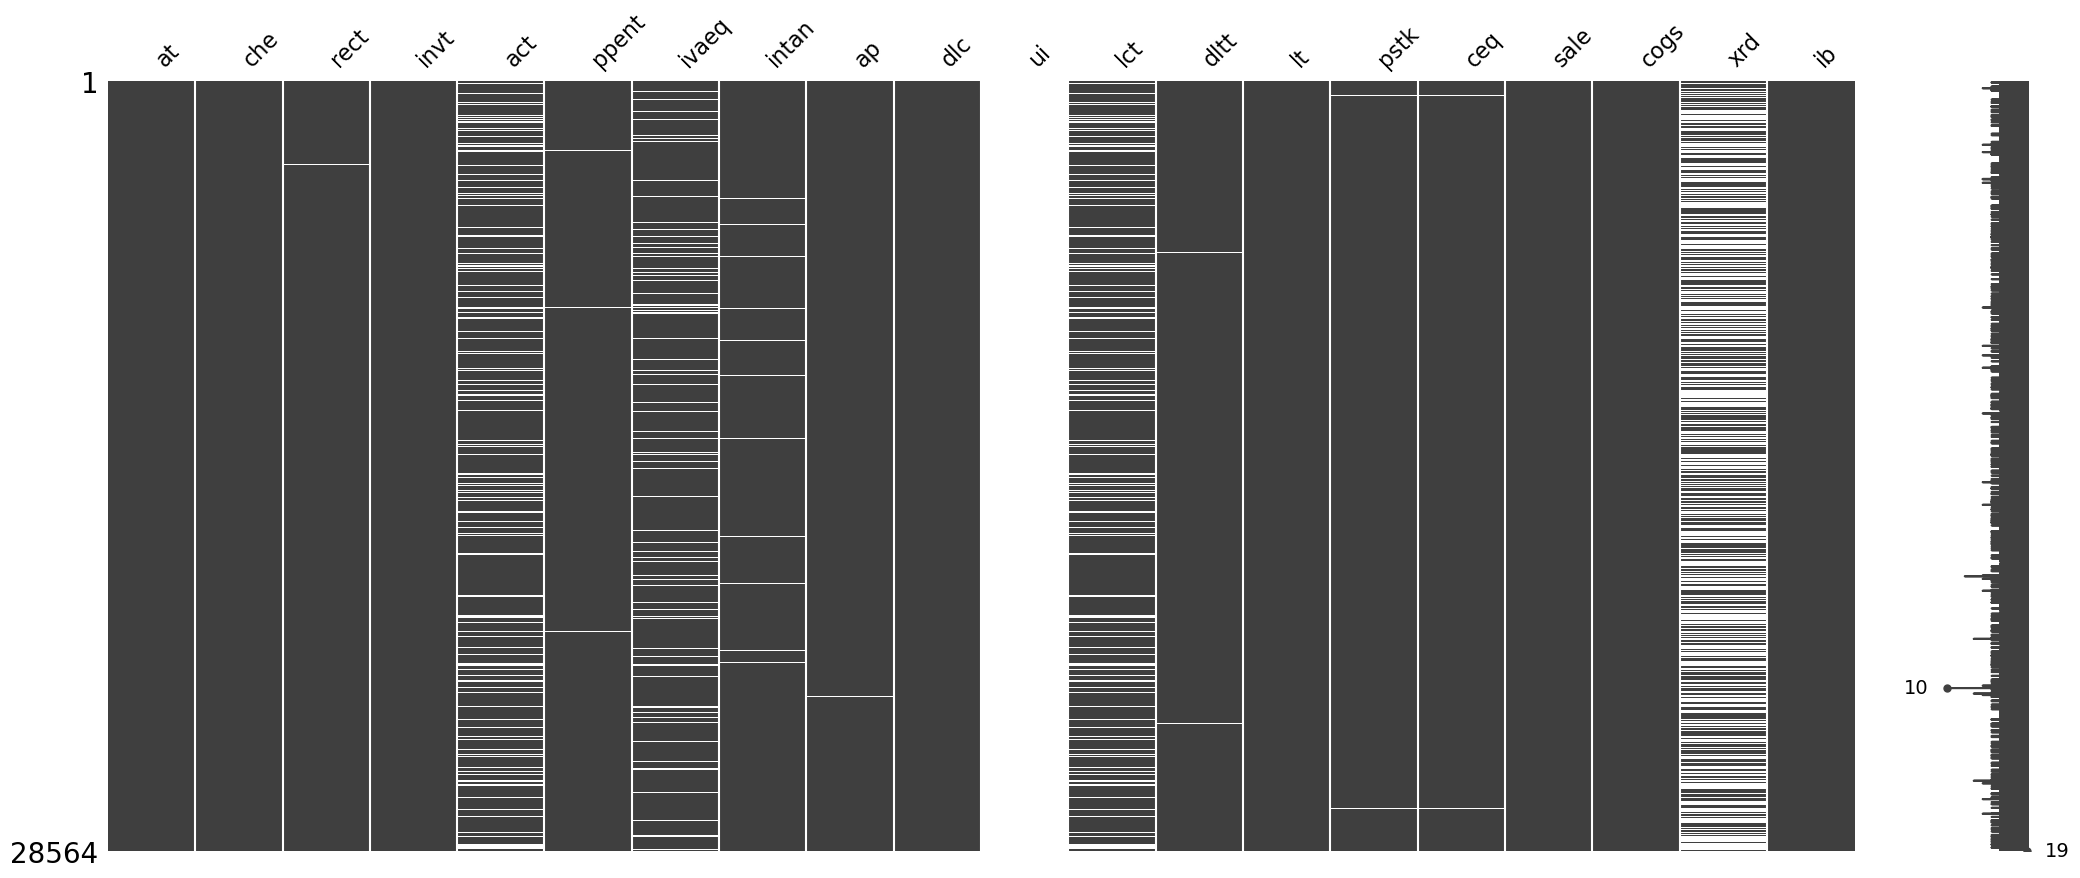

In [29]:
# MCAR test and structure of missing values
def mcar(dataset):
    # Visual inspection
    msno.matrix(dataset)

    # Little's MCAR test
    missing_data = dataset.isnull()
    mt = MCARTest(method="little")
    p_value = mt.little_mcar_test(dataset)
    print(f"p value: {p_value}")

mcar(explore_df.iloc[:, :-1])

This outcome suggests strong evidence against the null hypothesis of Missing Completely at Random (MCAR). \
The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.\
The distribution of missing values by sector.

### Identify the target attributes

In [30]:
# Extract levels of classes
def split_gics(codes):
    gics_l1 = []
    gics_l2 = []
    gics_l3 = []
    gics_l4 = []

    for code in codes:
        gics_l1.append(code[:2])
        gics_l2.append(code[2:4])
        gics_l3.append(code[4:6])
        gics_l4.append(code[6:8])

    output = pd.DataFrame({
        "GL1": gics_l1,
        "GL2": gics_l2,
        "GL3": gics_l3,
        "GL4": gics_l4
    })
    
    return output

h_gics = split_gics(explore_df["GICS"])

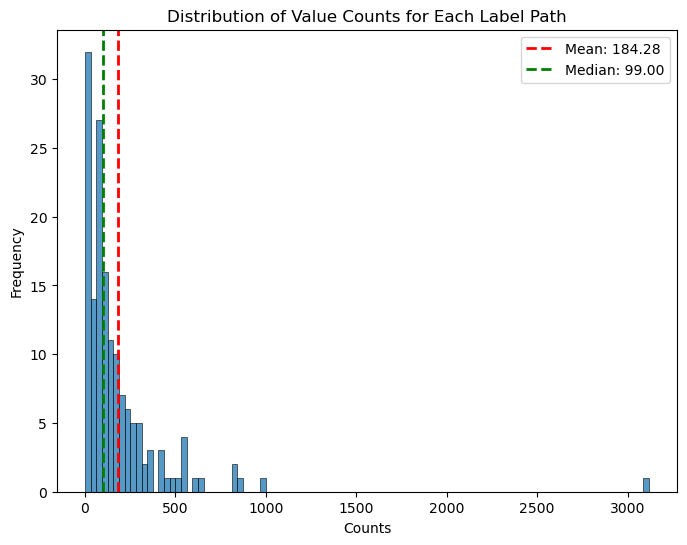

In [31]:
# Distribution of labels

# Group by the specified label levels and get the size of each group
labels_dist = h_gics.groupby(["GL1", "GL2", "GL3", "GL4"]).size()

# Convert the Series to a DataFrame and rename the column to 'counts'
labels_dist_df = labels_dist.reset_index(name='counts')

# Calculate average and median
mean_value = labels_dist_df['counts'].mean()
median_value = labels_dist_df['counts'].median()

# Create the histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(data=labels_dist_df, x='counts', bins=100)

# Add vertical lines for mean and median
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Add labels and title
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Value Counts for Each Label Path')
plt.legend()

# Show the plot
plt.show()

In [32]:
# Statistical summary
labels_dist.describe()

count     155.000000
mean      184.283871
std       298.323688
min         1.000000
25%        48.500000
50%        99.000000
75%       206.000000
max      3118.000000
dtype: float64

# 3 Prepare the data
Write functions for all data transformation

In [33]:
# Create a copy of data
prepare_df = train_X.copy(deep=True)

In [34]:
prepare_df = prepare_df.fillna(0)

In [35]:
# Data engineering
def data_eng(dataset):
    new_data = pd.DataFrame({

    # Compute common size components
    ## Assets
    "A1" : dataset["che"] / dataset["at"],   # Cash & Marketable Securities
    "A2" : dataset["rect"] / dataset["at"],  # Receivables
    "A3" : dataset["invt"] / dataset["at"],  # Inventories
    "A4" : dataset["act"] / dataset["at"],   # Total current assets
    "A5" : dataset["ppent"] / dataset["at"], # Net Plant & Equipment
    "A6" : dataset["ivaeq"] / dataset["at"], # Investments
    "A7" : dataset["intan"] / dataset["at"], # Goodwill & Intangibles

    ## Liabilities
    "L1" : dataset["ap"] / dataset["at"],   # Accounts Payable
    "L2" : dataset["dlc"] / dataset["at"],  # Total debt in current liabilities
    
    "L4" : dataset["lct"] / dataset["at"],  # Total current liabilities
    "L5" : dataset["dltt"] / dataset["at"], # total long-term debt
    "L6" : dataset["lt"] / dataset["at"],   # Total liabilities

    ## Equity
    "E1" : dataset["pstk"] / dataset["at"], # Preferred stock
    "E2" : dataset["ceq"] / dataset["at"],  # Common stock

    ## Ratios
    "R1" : (dataset["sale"] - dataset["cogs"]) / dataset["sale"],                  # Gross Margin
    "R2" : dataset["xrd"] / dataset["sale"],                                       # R&D/Sales
    "R3" : dataset["ib"] / dataset["sale"],                                        # Net Income/Sales
    "R4" : dataset["rect"] * (dataset["sale"] / 365),                              # Days of Receivables
    "R5" : dataset["cogs"] / dataset["invt"],                                      # Inventory Turnover
    "R6" : dataset["sale"] / dataset["ppent"],                                     # Fixed Asset Turnover
    "R7" : dataset["sale"] / dataset["at"],                                        # Total Asset Turnover
    "R8" : dataset["ib"] /  dataset["at"],                                         # Net Income/Assets
    "R9" : dataset["ib"] / dataset["ceq"],                                         # Net Income/Equity
    "R10" : dataset["at"] / dataset["ceq"],                                        # Assets/Equity
    "R11" : (dataset["dlc"] + dataset["dltt"]) / dataset["ceq"],                   # Debt/Equity
    "R12" : dataset["dltt"] / (dataset["pstk"] + dataset["ceq"] + dataset["dltt"]) # L/T Debt/Total Capital
    })

    return new_data

new_prepare_df = data_eng(prepare_df)

In [36]:
# % of missing values
prop_na_col2 = round((new_prepare_df.isna().sum() / len(new_prepare_df)) * 100, 2).sort_values(ascending=False)
prop_na2 = round((new_prepare_df.isna().sum().sum() / new_prepare_df.size) * 100, 2)

print(f"Proportion of missing values in each attributes:")
print(prop_na_col2)
print(f"\n{prop_na2}% values are missing in total.")

Proportion of missing values in each attributes:
A1     0.0
A2     0.0
R11    0.0
R10    0.0
R9     0.0
R8     0.0
R7     0.0
R6     0.0
R5     0.0
R4     0.0
R3     0.0
R2     0.0
R1     0.0
E2     0.0
E1     0.0
L6     0.0
L5     0.0
L4     0.0
L2     0.0
L1     0.0
A7     0.0
A6     0.0
A5     0.0
A4     0.0
A3     0.0
R12    0.0
dtype: float64

0.0% values are missing in total.


In [37]:
# % of infinite values

prop_inf_col = round((((new_prepare_df == np.inf) | (new_prepare_df == -np.inf)).sum() / len(new_prepare_df)) * 100, 2).sort_values(ascending=False)
prop_inf = round((((new_prepare_df == np.inf) | (new_prepare_df == -np.inf)).sum().sum() / new_prepare_df.size) * 100, 2)

print(f"Proportion of infinite values in each attribute:")
print(prop_inf_col)
print(f"\n{prop_inf}% values are infinite in total.")

Proportion of infinite values in each attribute:
R6     0.55
R11    0.19
R10    0.19
R9     0.19
A1     0.00
A2     0.00
R8     0.00
R7     0.00
R5     0.00
R4     0.00
R3     0.00
R2     0.00
R1     0.00
E2     0.00
E1     0.00
L6     0.00
L5     0.00
L4     0.00
L2     0.00
L1     0.00
A7     0.00
A6     0.00
A5     0.00
A4     0.00
A3     0.00
R12    0.00
dtype: float64

0.04% values are infinite in total.


In [39]:
# Replace inf values into na
def handle_inf(dataset):
    dataset = dataset.replace([np.inf, -np.inf], np.nan)

    return dataset

new_prepare_df = handle_inf(new_prepare_df.iloc[:, 14:])

In [40]:
def data_scale_impute(dataset):
    # Feature scaling
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(dataset)

    # Imputation
    imputer = SimpleImputer(strategy="mean")
    imputed_data = imputer.fit_transform(scaled_data)

    return imputed_data

imputed_data = data_scale_impute(new_prepare_df)

In [41]:
imputed_data_df = pd.DataFrame(imputed_data, columns=new_prepare_df.columns, index=new_prepare_df.index)
imputed_data_df = pd.concat([imputed_data_df, train_y], axis=1)

In [42]:
def feature_transform(X, y, random_state=42, balance=False, s=0.3):
    full_data = pd.concat([X, y], axis=1)
    data1 = data_eng(full_data)
    data2 = handle_inf(data1)
    data3 = data_scale_impute(data2)

    if balance == False:
        X = data3
        y = split_gics(y)

    if balance == True:
        data3_df = pd.DataFrame(data3, columns=data1.columns, index=data1.index)
        data3_df = pd.concat([data3_df, y], axis=1)
        balanced_data = HROS_FD(data3_df, label="GICS", random_state=random_state, s=s)
        X = np.array(balanced_data.iloc[:, :-1])
        y = split_gics(balanced_data.iloc[:, -1])

    return X, y.to_numpy()

# 4 Shortlist promising models
For large dataset, it is better to sample smaller training sets to have a reasonable training time, but this penalizes complex models such as large neural nets and random forests. \
Automate these steps.

In [43]:
ub_train_X, ub_train_y = feature_transform(train_X, train_y)

In [44]:
balanced_data = HROS_FD(imputed_data_df, label="GICS", random_state=42, s=0.3)

b_train_X, b_train_y = feature_transform(train_X, train_y, balance=True)

In [45]:
# K-fold cross-validation
def cv_f1(x, y, random_state, n_splits, shuffle, model):

    kfold = KFold(random_state=random_state, n_splits=n_splits, shuffle=shuffle)

    h_f1 = []

    for train_index, valid_index in kfold.split(x, y):

        X_train, X_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test data
        y_pred = model.predict(X_valid)

        # Evaluate the model (replace with your metric)
        score = f1(y_valid, y_pred)
        h_f1.append(score)

    # Convert scores to a numpy array for convenience
    h_f1 = np.array(h_f1)

    return h_f1

In [48]:
# Train models using standard parameters
tree_clf = DecisionTreeClassifier(random_state=42)
lgb_clf = LGBMClassifier(random_state=42, n_jobs=-1, force_col_wise=True, verbose=-1)
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

flat_tree = FlatClassifier(local_classifier=tree_clf)
flat_lgb = FlatClassifier(local_classifier=lgb_clf)
flat_rf = FlatClassifier(local_classifier=rf_clf)

lcpn_tree = LocalClassifierPerNode(local_classifier=tree_clf, binary_policy="exclusive")
lcpn_lgb = LocalClassifierPerNode(local_classifier=lgb_clf, binary_policy="exclusive", n_jobs=-1)
lcpn_rf = LocalClassifierPerNode(local_classifier=rf_clf, binary_policy="exclusive", n_jobs=-1)

In [49]:
flat_tree_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=3, model=flat_tree, shuffle=True)
flat_lgb_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=3, model=flat_lgb, shuffle=True)
flat_rf_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=3, model=flat_rf, shuffle=True)

print("flat_tree_f1_ub: ", flat_tree_f1_ub.mean(), flat_tree_f1_ub.std())
print("flat_lgb_f1_ub: ", flat_lgb_f1_ub.mean(), flat_lgb_f1_ub.std())
print("flat_rf_f1_ub: ", flat_rf_f1_ub.mean(), flat_rf_f1_ub.std())

flat_tree_f1_ub:  0.7890045056210576 0.001850133131440733
flat_lgb_f1_ub:  0.5205862263213349 0.040460072675868465
flat_rf_f1_ub:  0.8907726744622858 0.002545721482340373


In [50]:
flat_tree_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=3, model=flat_tree, shuffle=True)
flat_lgb_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=3, model=flat_lgb, shuffle=True)
flat_rf_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=3, model=flat_rf, shuffle=True)

print("flat_tree_f1_b: ", flat_tree_f1_b.mean(), flat_tree_f1_b.std())
print("flat_lgb_f1_b: ", flat_lgb_f1_b.mean(), flat_lgb_f1_b.std())
print("flat_rf_f1_b: ", flat_rf_f1_b.mean(), flat_rf_f1_b.std())

flat_tree_f1_b:  0.8429104000247141 0.0011531424601833053
flat_lgb_f1_b:  0.5252645970228015 0.022758025679792144
flat_rf_f1_b:  0.9184028819405002 0.001500620748231328


In [ ]:
h_tree_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=3, model=lcpn_tree, shuffle=True)
h_lgb_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=3, model=lcpn_lgb, shuffle=True)
h_rf_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=3, model=lcpn_rf, shuffle=True)

print("h_tree_f1_ub: ", h_tree_f1_ub.mean(), h_tree_f1_ub.std())
print("h_lgb_f1_ub: ", h_lgb_f1_ub.mean(), h_lgb_f1_ub.std())
print("h_rf_f1_ub: ", h_rf_f1_ub.mean(), h_rf_f1_ub.std())

In [ ]:
h_tree_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=3, model=lcpn_tree, shuffle=True)
h_lgb_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=3, model=lcpn_lgb, shuffle=True)
h_rf_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=3, model=lcpn_rf, shuffle=True)

print("h_tree_f1_b: ", h_tree_f1_b.mean(), h_tree_f1_b.std())
print("h_lgb_f1_b: ", h_lgb_f1_b.mean(), h_lgb_f1_b.std())
print("h_rf_f1_b: ", h_rf_f1_b.mean(), h_rf_f1_b.std())